# 插值

In [2]:
from sympy import *

拉格朗日插值

In [3]:
def lagrange_interpolate(points: list, simplify_result=True, verbose=False):
    """拉格朗日插值

    Args:
        points: list, [(x1, y1), (x2, y2), ..., (xn, yn)]
        simplify_result: bool, 化简最终结果, default True
        verbose: bool, 输出每一步的结果, default False

    Returns: 
        L: sympy object of Symbol('x'), 插值多项式 $L(x)$
    """
    x = Symbol('x')
    L = 0  # 插值多项式
    for i, point in enumerate(points):
        xi, yi = point
        li = 1
        for j in range(len(points)):
            if j == i:
                continue
            xj, yj = points[j]
            li *= (x - xj) / (xi - xj)
        L += yi * li
        if verbose:
            print(f"l_{i}(x) = ", simplify(expand(yi * li)))
        
    if simplify_result:
        L = simplify(L)
    return L

In [4]:
points = [(11, 0.190809), (12, 0.207912), (13, 0.224951)]

L = lagrange_interpolate(points)
print('插值多项式:', L)
print('Hypothesis:  ', L.subs(Symbol('x'), 11.5))
print('Actual vaule:', sin(rad(11.5)).evalf())

插值多项式: -3.20000000000042e-5*x**2 + 0.0178390000000004*x - 0.00154799999999966
Hypothesis:   0.199368500000004
Actual vaule: 0.199367934417197


牛顿插值

In [5]:
# 差商缓存
__difference_quotient_cache = {}

def difference_quotient(f, xs: list, verbose=False):
    """求差商 $f[xs...]$
    
    Args:
        f: function, 函数
        xs: list, 要计算的差商的 $f[x0, x1, ...]$ 的参数值：[x0, x1, ...]
        verbose: bool, 打印出每一步计算差商的值, default False

    Returns:
        dq: sympy object, 差商值
    """

    # 尝试从缓存读取
    __key = str([(x, f(x)) for x in xs])
    if __key in __difference_quotient_cache:
        if verbose:
            print(f"cached: f{xs}: {__difference_quotient_cache[__key]}")
        return __difference_quotient_cache[__key]

    if len(xs) == 1: # 0阶
        dq = sympify(f(xs[0]))
    else: # n 阶
        dq_h = difference_quotient(f, xs[:-1], verbose)
        dq_l = difference_quotient(f, xs[1: ], verbose)
        dq = (dq_l - dq_h) / (xs[-1] - xs[0])
    
    if verbose:
        print(f"f{xs}: {dq}")

    # 写入缓存
    __difference_quotient_cache[__key] = dq

    return dq

In [6]:
def newton_interpolate(points: list, N_start=0, points_start=[], simplify_result=True, verbose=False):
    """牛顿插值

    Args:
        points: [(x1, y1), (x2, y2), ..., (xn, yn)]： 插值点

        N_start: a sympy object of Symbol('x'), 起始插值多项式。
        points_start: [(x1, y1), (x2, y2), ..., (xn, yn)]: 计算 N_start 用的插值点
                 该函数中做的插值会「承袭」这个用 points_start 计算的 N_start，在其基础上用新增插值点 points 去改进。
                 default 0 (从头开始构建).

        simplify_result: bool, 化简最终结果, default True
        verbose: 打印出每一步计算差商的值, default False

    Returns: 
        N: a sympy object of Symbol('x'), 插值多项式 $N(x)$
    """
    x = Symbol('x')
    
    # sympify points
    # for i in range(len(points)):
    #     points[i] = sympify(points[i][0]), sympify(points[i][1])
    
    f = lambda x: dict(points + points_start)[x]
    
    xs = [p[0] for p in points_start] # 承袭的插值点
    N = N_start   # 承袭的插值多项式
    for point in points:
        xs.append(point[0])
        N += difference_quotient(f, xs, verbose) * prod([x - xi for xi in xs[:-1]])
    
    if simplify_result:
        N = simplify(N)
    return N

In [7]:
points = [(11, 0.190809), (12, 0.207912), (13, 0.224951)]

N = newton_interpolate(points)
print('插值多项式:', N)
print('Hypothesis:  ', N.subs(Symbol('x'), 11.5))
print('Actual vaule:', sin(rad(11.5)).evalf())

# 承袭之前的 N:
print('承袭:')
new_points = [(11.2, sin(rad(11.2)).evalf()), (11.7, sin(rad(11.7)).evalf())]
N1 = newton_interpolate(new_points, N_start=N, points_start=points, verbose=True)
print('插值多项式:', N1)
print('Hypothesis:  ', N1.subs(Symbol('x'), 11.5).evalf())
print('Actual vaule:', sin(rad(11.5)).evalf())

插值多项式: -3.20000000000042e-5*x**2 + 0.0178390000000001*x - 0.00154800000000063
Hypothesis:   0.199368500000000
Actual vaule: 0.199367934417197
承袭:
cached: f[11, 12, 13]: -0.0000320000000000042
cached: f[12, 13]: 0.0170390000000000
cached: f[13]: 0.224951000000000
f[11.2]: 0.194234351219972
f[13, 11.2]: 0.0170648048777933
f[12, 13, 11.2]: -0.0000322560972416778
f[11, 12, 13, 11.2]: -0.00000128048620836791
cached: f[11, 12, 13, 11.2]: -0.00000128048620836791
cached: f[12, 13, 11.2]: -0.0000322560972416778
cached: f[13, 11.2]: 0.0170648048777933
cached: f[11.2]: 0.194234351219972
f[11.7]: 0.202787295356512
f[11.2, 11.7]: 0.0171058882730810
f[13, 11.2, 11.7]: -0.0000316026117597499
f[12, 13, 11.2, 11.7]: -0.00000217828493975971
f[11, 12, 13, 11.2, 11.7]: -0.00000128256961627400
插值多项式: -1.282569616274e-6*x**4 + 5.9256799679765e-5*x**3 - 0.00105582207039453*x**2 + 0.0256792199573976*x - 0.0240006476355346
Hypothesis:   0.199367875528590
Actual vaule: 0.199367934417197


In [8]:
__difference_quotient_cache

{'[(11, 0.190809)]': 0.190809000000000,
 '[(12, 0.207912)]': 0.207912000000000,
 '[(11, 0.190809), (12, 0.207912)]': 0.0171030000000000,
 '[(13, 0.224951)]': 0.224951000000000,
 '[(12, 0.207912), (13, 0.224951)]': 0.0170390000000000,
 '[(11, 0.190809), (12, 0.207912), (13, 0.224951)]': -3.20000000000042e-5,
 '[(11.2, 0.194234351219972)]': 0.194234351219972,
 '[(13, 0.224951), (11.2, 0.194234351219972)]': 0.0170648048777933,
 '[(12, 0.207912), (13, 0.224951), (11.2, 0.194234351219972)]': -3.22560972416778e-5,
 '[(11, 0.190809), (12, 0.207912), (13, 0.224951), (11.2, 0.194234351219972)]': -1.28048620836791e-6,
 '[(11.7, 0.202787295356512)]': 0.202787295356512,
 '[(11.2, 0.194234351219972), (11.7, 0.202787295356512)]': 0.0171058882730810,
 '[(13, 0.224951), (11.2, 0.194234351219972), (11.7, 0.202787295356512)]': -3.16026117597499e-5,
 '[(12, 0.207912), (13, 0.224951), (11.2, 0.194234351219972), (11.7, 0.202787295356512)]': -2.17828493975971e-6,
 '[(11, 0.190809), (12, 0.207912), (13, 0.22

三弯矩法

In [97]:
import numpy as np

def spline3_interpolate(points: list, simplify_result=True):
    """三弯矩法插值

    三弯矩法进行三次样条插值。使用自由边界条件。

    Args:
        points: list, [(x1, y1), (x2, y2), ..., (xn, yn)]
        simplify_result: bool, 化简最终结果, default True

    Returns: 
        L: sympy Piecewise object of Symbol('x'), 插值多项式 $L(x)$
    """
    # 排序给定的点
    ps = sorted(points, key=lambda p: p[0])
    n = len(points)

    # points to a function
    _f_dict = dict(ps)
    def f(x):
        return _f_dict[x]

    # $h_k = x_{k+1} - x_k$
    def h(k):
        return ps[k+1][0] - ps[k][0]

    hks = [h(0)]

    # 用方程 D * M = d 解出 M

    D = np.zeros((n, n))
    d = np.zeros(n)

    for k in range(1, n-1):
        # $h_k$, $h_{k-1}$
        hks.append(h(k))
        hk, hks1 = hks[k], hks[k-1]

        # $\mu_k$ -> mu, $\lambda_k$ -> ld
        _fra = hks1 + hk
        mu = hks1 / _fra
        ld = hk / _fra

        # $\mu_kM_{k-1}+2M_k+\lambda_kM_{k+1} = d_k$
        D[k, k-1] = mu
        D[k, k]   = 2
        D[k, k+1] = ld
        d[k] = 6 * difference_quotient(f, [ps[k-1][0], ps[k][0], ps[k+1][0]])

    # 边界条件
    # Natural Boundary
    D[0, 0] = 1
    D[n-1, n-1] = 1

    d[0] = 0
    d[n-1] = 0

    # 解出 M
    M = np.linalg.solve(D, d)

    # 插值函数
    piecewises = []
    for k in range(n-1):
        s  = M[k] * (ps[k+1][0] - _x) ** 3 / (6 * hks[k])
        s += M[k+1] * (_x - ps[k][0]) ** 3 / (6 * hks[k])
        s += (ps[k][1] - M[k] * hks[k]**2 / 6) * (ps[k+1][0] - _x) / hks[k]
        s += (ps[k+1][1] - M[k+1] * hks[k]**2 / 6) * (_x - ps[k][0]) / hks[k]
        if simplify_result:
            s = simplify(s)
        piecewises.append((s, And(_x >= ps[k][0], _x <= ps[k+1][0])))

    return Piecewise(*piecewises)

题目
2．区间 $[-5, 5]$ 作等距划分：...

In [15]:
def f(x):
    return 1 / (1 + x ** 2)

def get_points(s, n, f):
    """在闭区间 s 作 n 等距划分, 输出 n+1 个插值点 [(x0, f(x0)), (x1, f(x1)), ..., (xn, f(xn))]
    e.g. 
        get_points([-5, 5], 2, lambda x: 1 / (1 + x ** 2))
    output: [(-5.0, 0.038461538461538464), (0.0, 1.0), (5.0, 0.038461538461538464)]
    """
    h = (s[1] - s[0]) / n
    xs = [s[0] + k * h for k in range(n+1)]
    points = [(x, f(x)) for x in xs]
    return points

In [100]:
hps = {}  # 多项式插值
hss = {}  # 三次样条插值
for n in [5, 10, 20]:
    ps = get_points([-5, 5], n, f)
    # 多项式插值
    # h = lagrange_interpolate(ps)
    h = newton_interpolate(ps)
    hps[n] = h

    # 三次样条插值
    s = spline3_interpolate(ps)
    hss[n] = s

print('多项式插值：')
for k in hps:
    print(f'n = {k}:\t{hps[k]}')
print('\n三次样条插值：')
for k in hss:
    print(f'n = {k}:\t{hss[k]}')

多项式插值：
n = 5:	0.00192307692307692*x**4 - 0.0692307692307692*x**2 + 0.567307692307692
n = 10:	-2.26244343891403e-5*x**10 + 0.00126696832579186*x**8 + 8.67361737988404e-19*x**7 - 0.0244117647058824*x**6 - 6.93889390390723e-18*x**5 + 0.19737556561086*x**4 + 5.55111512312578e-17*x**3 - 0.67420814479638*x**2 + 2.4980018054066e-16*x + 1.0
n = 20:	2.72817068149796e-9*x**20 - 2.65314598775677e-7*x**18 + 2.11758236813575e-22*x**17 + 1.07425130797334e-5*x**16 - 0.000236412102809886*x**14 + 5.42101086242752e-20*x**13 + 0.00310184793200599*x**12 - 4.33680868994202e-19*x**11 - 0.0251135266738695*x**10 + 1.04083408558608e-17*x**9 + 0.126252909857124*x**8 - 4.16333634234434e-17*x**7 - 0.391630076762969*x**6 + 1.52655665885959e-16*x**5 + 0.753353962815113*x**4 - 8.32667268468867e-17*x**3 - 0.965739184991246*x**2 + 8.50014503228635e-17*x + 1.0

三次样条插值：
n = 5:	Piecewise((-0.0242914979757085*x + 1.72064777327935*(0.2*x + 1)**3 - 0.0829959514170041, (x >= -5.0) & (x <= -3.0)), (-0.0265182186234818*x**3 - 

In [102]:
# 画图
def show_plot_range(r, hs, title):
    """画图比较插值结果
    r：区间
    hs: 插值结果组 {n: h(x)}
    title: 图标题
    """
    x = Symbol('x')
    colors = (c for c in [0, 'b', 'g', 'r'])

    plt = plot(f(x), (x, *r), show=False, line_color=next(colors), label='f(x)', legend=True, title=title)
    for n in hs:
        p = plot(hs[n], (x, *r), show=False, line_color=next(colors), label=f'n={n}', legend=True)
        plt.extend(p)
    
    plt.show()

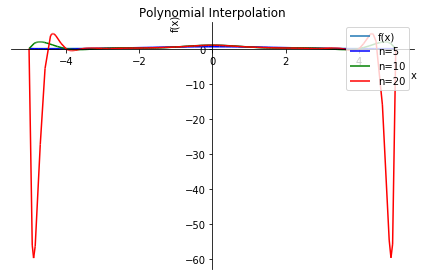

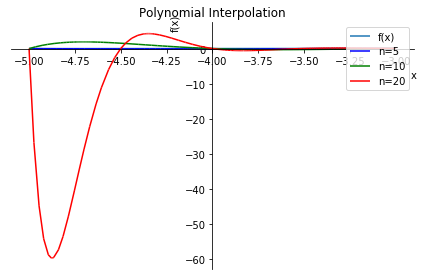

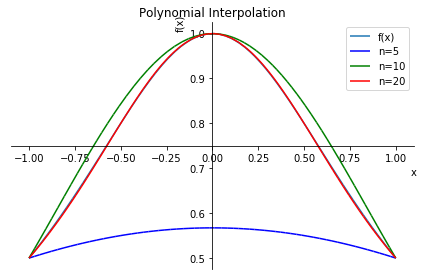

In [103]:
# 画图：多项式插值
show_plot_range((-5, 5), hps, 'Polynomial Interpolation')
show_plot_range((-5, -3), hps, 'Polynomial Interpolation')
show_plot_range((-1, 1), hps, 'Polynomial Interpolation')

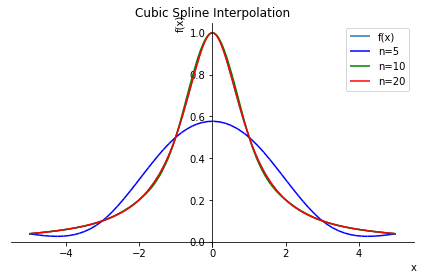

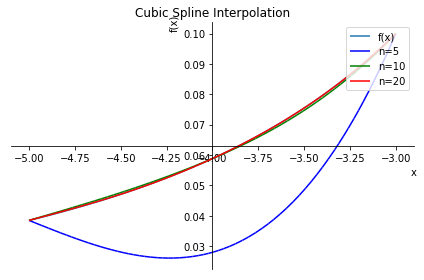

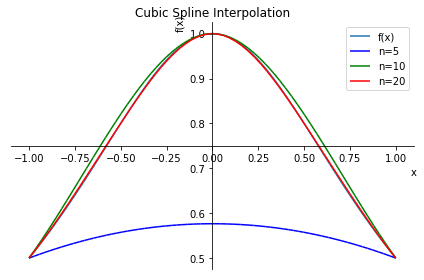

In [105]:
# 画图：三次样条插值
show_plot_range((-5, 5), hss, 'Cubic Spline Interpolation')
show_plot_range((-5, -3), hss, 'Cubic Spline Interpolation')
show_plot_range((-1, 1), hss, 'Cubic Spline Interpolation')

# 拟合

In [159]:
def normalEquationFit(X, y):
    """最小二乘拟合
    Compute the normal equations:

    $\theta = (X^TX)^{-1}X^Ty$

    Args:
        X: np.array, $$
            X = \left[\begin{array}{c}
            - (x^{(1)})^T - \\
            - (x^{(2)})^T - \\
            \vdots \\
            - (x^{(m)})^T - \\
            \end{array}\right]
        $$
        y: np.array, $y = [y^{(1)},y^{(2)},\dots,y^{(m)}]^T$

    return theta.
    """
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), y)

题目：3.4.2 数据拟合 1.

In [160]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 4.5, 6, 8, 8.5])

X = np.c_[np.ones((len(x), 1)), x]

theta = normalEquationFit(X, y)
print(theta)

pred_f = lambda t: theta[0] + theta[1] * t

[2.45 1.25]


In [125]:
# 用梯度下降检查

a, b = 0, 0

num_epoch = 10000
learning_rate = 5e-4

for e in range(num_epoch):
    y_pred = a * x + b
    
    grad_a = 2 * (y_pred - y).dot(x)
    grad_b = 2 * (y_pred - y).sum()
    
    a = a - learning_rate * grad_a
    b = b - learning_rate * grad_b

print(a, b)

1.2501150707283306 2.449584558158982


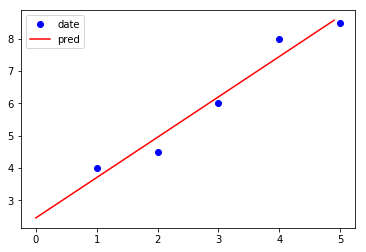

In [143]:
# 画图
import matplotlib.pyplot as plt

pred_x = [k/10 for k in range(50)]
pred_y = [pred_f(x) for x in pred_x]

plt.plot(x, y, 'bo', label='date')
plt.plot(pred_x, pred_y, 'r-', label='pred')
plt.legend()
plt.show()

### 题目：3.4.2 数据拟合 2.



In [177]:
x = np.array([2, 3, 4, 7, 8, 10, 11, 14, 16, 18, 19])
y = np.array([106.42, 108.2, 109.5, 110, 109.93, 110.49, 110.59, 110.6, 110.76, 111, 111.2])

(1) $y(x) = c_0 + c_1x + c_2x^2$

数据预处理：

In [163]:
# X: [1, x, x**2]
X = np.c_[np.ones((len(x), 1)), x, x ** 2]
print(X)

[[  1.   2.   4.]
 [  1.   3.   9.]
 [  1.   4.  16.]
 [  1.   7.  49.]
 [  1.   8.  64.]
 [  1.  10. 100.]
 [  1.  11. 121.]
 [  1.  14. 196.]
 [  1.  16. 256.]
 [  1.  18. 324.]
 [  1.  19. 361.]]


定义预测函数、代价函数：

In [165]:
def hypothesis(x, theta):
    return np.dot(theta, np.array([1, x, x**2]))

def cost(x, y, hypothesis, theta):
    return np.sum( (hypothesis(x, theta) - y) ** 2 )

最小二乘正规方程拟合：

In [166]:
# theta: [c0, c1, c2]
theta = normalEquationFit(X, y)
theta

array([ 1.06292705e+02,  6.26350752e-01, -2.04540298e-02])

计算代价：

In [176]:
cost(x, y, hypothesis, theta)

2.7796090121179953

可视化拟合：

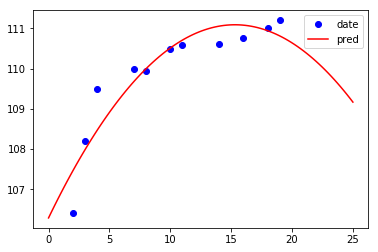

In [174]:
x_test = np.linspace(0, 25, num=100, endpoint=True)
y_pred = hypothesis(x_test, theta)

plt.plot(x, y, 'bo', label='date')
plt.plot(x_test, y_pred, 'r-', label='pred')
plt.legend()
plt.show()

(2) $y(x) = ae^{\frac{b}{x}}$

取对数：$\ln(y) = \ln(a) + \frac{b}{x}$

数据预处理：

In [179]:
# X: [1, 1/x]
X = np.c_[np.ones((len(x), 1)), 1 / x]
print(X)

[[1.         0.5       ]
 [1.         0.33333333]
 [1.         0.25      ]
 [1.         0.14285714]
 [1.         0.125     ]
 [1.         0.1       ]
 [1.         0.09090909]
 [1.         0.07142857]
 [1.         0.0625    ]
 [1.         0.05555556]
 [1.         0.05263158]]


新的预测函数：

In [197]:
def hypothesis(x, theta):
    a, b = theta
    h = np.exp(a) * np.exp(b / x)
    return h

拟合：

In [192]:
# theta: [ln(a), b]
theta = normalEquationFit(X, np.log(y))
theta

array([ 4.7139705 , -0.09032026])

代价计算：

In [198]:
cost(x, y, hypothesis, theta)

0.47193209161233546

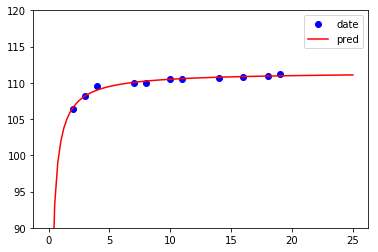

In [256]:
x_test = np.linspace(0, 25, num=100, endpoint=True)
y_pred = hypothesis(x_test, theta)

plt.plot(x, y, 'bo', label='date')
plt.plot(x_test, y_pred, 'r-', label='pred')
plt.ylim(90, 120)
plt.legend()
plt.show()